# Example: Static inverse free-boundary equilibrium calculations

---

This example notebook shows how to use FreeGSNKE to solve **static inverse** free-boundary Grad-Shafranov (GS) problems. 

In the **inverse** solve mode we seek to estimate the active poloidal field coil currents using user-defined constraints (e.g. on isoflux, x-point, o-point, and psi values) and plasma current density profiles for a desired equilibrium shape. 

Note that during this solve, currents are **not** found in any specified passive structures. 

Below, we illustrate how to use the solver for both diverted and limited plasma configurations in a **MAST-U-like tokamak** using stored pickle files containing the machine description. These machine description files partially come from the FreeGS repository and are not an exact replica of MAST-U.

### The static free-boundary Grad-Shafranov problem

Here we will outline the **static free-boundary** GS problem that is solved within both the **forward** and **inverse** solvers, though we encourage you to see [Pentland et al. (2024)](https://arxiv.org/abs/2407.12432) for more details. 

Using a cylindrical coordinate system $(R,\phi,Z)$, the aim is to solve the GS equation:

$$ \Delta^* \psi \equiv \left( \frac{\partial^2}{\partial R^2} - \frac{1}{R} \frac{\partial}{\partial R} + \frac{\partial^2}{\partial Z^2} \right) \psi = -\mu_0 R J_{\phi}(\psi, R, Z), \qquad (R,Z) \in \Omega, $$

for the poloidal flux $\psi(R,Z)$ (which here has units Weber/$2\pi$) in the rectangular computational domain $\Omega$. The flux has contributions from both the plasma and the coils (metals) such that $\psi = \psi_p + \psi_c$. This flux defines the toroidal current density $J_{\phi} = J_p(\psi,R,Z) + J_c(R,Z)$, also containing a contribution from both the plasma and coils, respectively. We have the plasma current density (only valid in the core plasma region $\Omega_p$):

$$ J_p(\psi,R,Z) = R \frac{\mathrm{d}p}{\mathrm{d}\psi} +\frac{1}{\mu_0 R} F \frac{\mathrm{d} F}{\mathrm{d} \psi}, \qquad (R,Z) \in \Omega_p, $$

where $p(\psi)$ is the plasma pressure profile and $F(\psi)$ is the toroidal magnetic field profile. The current density generated by $N$ active coils and passive structures is given by:

$$ J_c(R,Z) = \sum_{j=1}^{N} \frac{I^c_j(R,Z)}{A_j^c}, \qquad (R,Z) \in \Omega, \quad \text{where} \quad I_j^c(R,Z) = 
\begin{cases} 
    I_j^c & \text{if } (R,Z) \in \Omega_j^c, \\ 
    0 & \text{elsewhere}.
\end{cases}.$$

This makes use of the current $I^c_j$ in each metal and its cross-sectional area $A^c_j$ (the domain of each metal is denoted by $\Omega_j^c$).

To complete the problem, we need the integral (Dirichlet) free-boundary condition:

$$ \psi(R,Z) = \int_{\Omega} G(R,Z;R',Z') J_{\phi}(\psi, R',Z') \ \mathrm{d}R' \mathrm{d}Z', \qquad (R,Z) \in \partial \Omega, $$

where $G$ is the (known) Green's function for the elliptic operator above.

We'll now go through the steps required to solve the **inverse** problem in FreeGSNKE. 

### Create the machine object

First, we build the machine object from previously created pickle files in the "machine_configs/MAST-U" directory. 

FreeGSNKE requires the following paths in order to build the machine:
- `active_coils_path`
- `passive_coils_path`
- `limiter_path`
- `wall_path`
- `magnetic_probe_path` (not required here)

In [1]:
# build machine
from freegsnke import build_machine
tokamak = build_machine.tokamak(
    active_coils_path=f"../machine_configs/MAST-U/MAST-U_like_active_coils.pickle",
    passive_coils_path=f"../machine_configs/MAST-U/MAST-U_like_passive_coils.pickle",
    limiter_path=f"../machine_configs/MAST-U/MAST-U_like_limiter.pickle",
    wall_path=f"../machine_configs/MAST-U/MAST-U_like_wall.pickle",
)

Active coils --> built from pickle file.
Passive structures --> built from pickle file.
Limiter --> built from pickle file.
Wall --> built from pickle file.
Magnetic probes --> none provided.
Resistance (R) and inductance (M) matrices --> built using actives (and passives if present).
Tokamak built.


Text(10.027777777777777, 0.5, 'Height, $Z$ [m]')

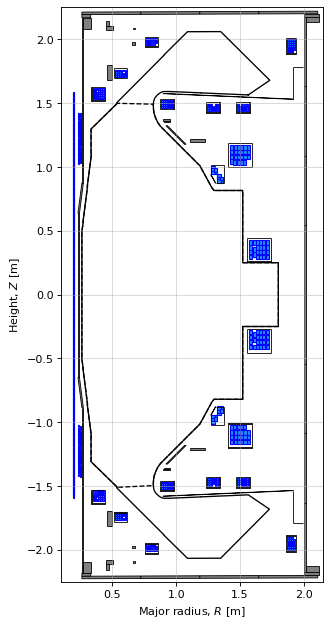

In [2]:
# plot the machine
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots(1, 1, figsize=(4, 8), dpi=80)
plt.tight_layout()

tokamak.plot(axis=ax1, show=False)
ax1.plot(tokamak.limiter.R, tokamak.limiter.Z, color='k', linewidth=1.2, linestyle="--")
ax1.plot(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, linestyle="-")

ax1.grid(alpha=0.5)
ax1.set_aspect('equal')
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
ax1.set_xlabel(r'Major radius, $R$ [m]')
ax1.set_ylabel(r'Height, $Z$ [m]')

### Instantiate an equilibrium

We are now ready to build a plasma equilibrium object for our tokamak. This is done using the `freegs4e.Equilibrium` class, which implicitly defines the rectangular domain of the solver as well as the grid resolution.

`Equilibrium` has sensible defaults, but it is recommended to define the radial and vertical domain of the grid using the `Rmin`, `Rmax`, `Zmin` and `Zmax` parameters, as well as the grid resolution in the radial and vertical directions with the `nx` and `ny` parameters. The grid will be initialised using fourth-order finite differences. Note that the computational grid **must** encompass the domain enclosed by the limiter object (as this is where the plasma will be confined to). 

A tokamak object should be supplied to the `tokamak` parameter to assign the desired machine to the equilibrium.

If available, an initial guess for the plasma flux $\psi_p$ (dimensions `nx` x `ny`) can be provided via the `psi` parameter (commented out in the following code). If not, the default initialisation will be used.  

The `eq` object will store a lot of important information and derived quantites once the equilibrium has been calculated (see future notebook on this). 

In [3]:
from freegsnke import equilibrium_update

eq = equilibrium_update.Equilibrium(
    tokamak=tokamak,      # provide tokamak object
    Rmin=0.1, Rmax=2.0,   # radial range
    Zmin=-2.2, Zmax=2.2,  # vertical range
    nx=65,                # number of grid points in the radial direction (needs to be of the form (2**n + 1) with n being an integer)
    ny=129,               # number of grid points in the vertical direction (needs to be of the form (2**n + 1) with n being an integer)
    # psi=plasma_psi
)

### Instantiate a profile object

We can now instatiate a profile object that contains the chosen parameterisation of the toroidal plasma current density $J_p$ (i.e. on right hand side of the GS equation). We can then set the paramters for the chosen current density profiles. 

The following table indicates which parameterisations are currently available in FreeGSNKE and for which types of equilibrium simulation they have been tested to work:

| Name | Static | Evolutive (linear) | Evolutive (nonlinear) |
|-------|--------|------------------|---------------------|
| `ConstrainPaxisIp` | ✅ | ✅ | ✅ |
| `ConstrainBetapIp` | ✅ | ✅ | ✅ |
| `FiestaTopeol` | ✅ | ✅ | ✅ |
| `Lao85` | ✅ | ✅ | ✅ |
| `TensionSpline` | ✅ | ❌ | ❌ |
| `GeneralPprimeFFprime` | ✅ | ❌ | ❌ |

In this notebook, we will make use of the `ConstrainPaxisIp` (and `ConstrainBetapIp`) profiles (see [Jeon (2015)](https://link.springer.com/article/10.3938/jkps.67.843)). Others will be utilised in later notebooks. If there is a profile parameterisation you require that does not exist, please do create an issue.

Both `ConstrainPaxisIp` and `ConstrainBetapIp` are parameterised as follows:
 $$J_{p}(\psi, R, Z) = \lambda\big[ \beta_{0} \frac{R}{R_{0}} \left( 1-\tilde{\psi}^{\alpha_m} \right)^{\alpha_n} + (1-\beta_{0}) \frac{R_0}{R} \left( 1-\tilde{\psi}^{\alpha_m} \right)^{\alpha_n} \big] \quad (R,Z) \in \Omega_p,$$

where the first term is the pressure profile and the second is the toroidal current profile. Here, $\tilde{\psi}$ denotes the normalised flux:
$$ \tilde{\psi} = \frac{\psi - \psi_a}{\psi_b - \psi_a}, $$
where $\psi_a$ and $\psi_b$ are the values of the flux on the magnetic axis and plasma boundary, respectively. 

The parameters required to define this particular profile are:
- `Ip` (total plasma current).
- `fvac` ($rB_{tor}$, vacuum toroidal field strength).
- `alpha_m`>0, and `alpha_n`>0 (that define the shape/peakedness of the profiles).
- If `ConstrainPaxisIp` is used, then `paxis` (pressure on the magnetic axis) is required.
- If `ConstrainBetapIp` is used, then `betap` (proxy of the poloidal beta) is required.


The values of $\lambda$ and $\beta_0$ are found using the above parameters as constraints ($R_0$ is a fixed scaling constant) in the following:

- For `ConstrainPaxisIp`, we can re-arrange the following equations to solve for the unknowns:

$$ p_{\text{axis}} = \lambda \beta_{0} \frac{R}{R_{0}} \int^{\psi_b}_{\psi_a} \left( 1-\tilde{\psi}^{\alpha_m} \right)^{\alpha_n} \mathrm{d} \tilde{\psi} $$

and

$$ I_p = \int^{Z_{\text{max}}}_{Z_{\text{min}}} \int^{R_{\text{max}}}_{R_{\text{min}}} J_p(\psi, R, Z) \ \mathrm{d}R \mathrm{d}Z. $$


- For `ConstrainBetapIp`, we can instead re-arrange and solve the following:

$$ \beta_p = \frac{8 \pi}{\mu_0 I_p^2} \int^{Z_{\text{max}}}_{Z_{\text{min}}} \int^{R_{\text{max}}}_{R_{\text{min}}} p(\psi) \ \mathrm{d}R \mathrm{d}Z. $$

and

$$I_p = \int^{Z_{\text{max}}}_{Z_{\text{min}}} \int^{R_{\text{max}}}_{R_{\text{min}}} J_p(\psi, R, Z) \ \mathrm{d}R \mathrm{d}Z. $$


In what follows, we use `ConstrainPaxisIp`. Note that the equilibrium (`eq`) object is passed to the profile to inform calculations relating to the machine description.

In [4]:
# initialise the profiles
from freegsnke.jtor_update import ConstrainPaxisIp
profiles = ConstrainPaxisIp(
    eq=eq,        # equilibrium object
    paxis=8e3,    # profile object
    Ip=6e5,       # plasma current
    fvac=0.5,     # fvac = rB_{tor}
    alpha_m=1.8,  # profile function parameter
    alpha_n=1.2   # profile function parameter
)

### Load the static nonlinear solver

We can now load FreeGSNKE's Grad-Shafranov static solver. The equilibrium is used to inform the solver of the computational domain and of the tokamak properties. The solver below can be used for **both** inverse and forward solves. 

Note: It's not necessary to instantiate a new solver when aiming to use it on new or different equilibria, as long as the integration domain, mesh grid, and tokamak are consistent across solves. 

In [5]:
from freegsnke import GSstaticsolver
GSStaticSolver = GSstaticsolver.NKGSsolver(eq)    

### Constraints

Recall that in the **inverse** solve mode we seek to **estimate the active poloidal field coil currents** using user-defined **constraints** (e.g. on isoflux, null points, and psi values) and plasma current density profiles for a desired equilibrium shape. 

FreeGSNKE uses a `constrain` object, which accepts constraints on the location of:
- any null points, which are either X-points or O-points (`null_points`).
- any pairs of points that lie on the same flux surface (`isoflux_set`). The flux at these locations will be constrained to be the same. Multiple sets can be defined. 
- any known flux points (`psi_vals`), i.e. one can specify $\psi$ at any location $(R,Z)$, possibly an entire flux map (not used here). 

At least one constraint (preferably many more) is required to carry out an inverse solve.

Here, we specify two X-point locations (we want a double null plasma) and a number of isoflux locations. The isofluxes here will define the core plasma shape and part of the divertor legs. 

In [6]:
import numpy as np 

Rx = 0.6      # X-point radius
Zx = 1.1      # X-point height
Ra = .85
Rout = 1.4    # outboard midplane radius
Rin = 0.34    # inboard midplane radius

# set desired null_points locations
# this can include X-point and O-point locations
null_points = [[Rx, Rx], [Zx, -Zx]]

# set desired isoflux constraints with format 
# isoflux_set = [isoflux_0, isoflux_1 ... ] 
# with each isoflux_i = [R_coords, Z_coords]
isoflux_set = np.array([[[Rx, Rx, Rin, Rout, 1.3, 1.3, .8,.8], [Zx, -Zx, 0.,0., 2.1, -2.1,1.62,-1.62]]])
           
# instantiate the freegsnke constrain object
from freegsnke.inverse import Inverse_optimizer
constrain = Inverse_optimizer(null_points=null_points,
                              isoflux_set=isoflux_set)

Given that there may be more or less constraints than unknown parameters (i.e. coil currents), the inverse problem may be over- or under-constrained. This means that there may be zero, one, or many solutions to the problem. 

A number of quadratic (i.e.Tikhonov) regularization parameters will be used to combat this. Larger values will encourage lower absolute coil current values. It is sometimes useful to experiment with different values to explore whether the converged solution departs from the desired constraints. 


### The linear system of constraints

During an inverse solve, a minmisation problem involving the responses, changes in coil currents, and constraints, is repeatedly solved:

$$ \min_{x} \| A\vec{x} - \vec{b}\|^2 + \| \gamma \vec{x} \|^2, $$

where
- $A$ is the fixed response matrix (that determines how a change in coil currents $x$, affects constraint values). 
- $\vec{x} = \Delta \vec{I}^c$ is the step change in active coil currents required to match the constraints. 
- $\vec{b}$ is the vector of constraint values being enforced. 
- $\gamma > 0$ is the regularisation parameter/vector.

We solve for $\vec{x}$ using a gradient-based optimiser. 

[Song et al. (2024)](https://www.mdpi.com/2571-6182/7/4/45) provide a nice overview of the inverse problem.


### Fixed coil currents

It is also possible to set values for the current in specific active poloidal field coils. The inverse solver will not allow the current in these coils to vary if the `control` parameter is set to `False` (i.e. it will be excluded during the optimisation). 

Note: any passive structures in the tokamak automatically have their control parameter set to False and are therefore not included in an inverse solve. 

As an example, we will fix the `Solenoid` current and seek a solution in which this value is fixed, rather than estimated by the inverse solve.

In [7]:
eq.tokamak.set_coil_current('Solenoid', 5000)
eq.tokamak['Solenoid'].control = False  # ensures the current in the Solenoid is fixed

### The inverse solve

The following cell will execute the solve. Since a `constrain` object is provided, this is interpreted as a call to the inverse solver, if `constrain=None`, then the forward solver will be called (see next notebook). The `target_relative_tolerance` is the maximum relative error on the plasma flux function allowed for convergence and `target_relative_psit_update` ensures that the relative update to the plasma flux (caused by the update in the control currents) is lower than this target value. Both are required to be met for the inverse problem to be considered successfully solved.

The `verbose=True` option will provide an indication of the progression of the solve. 

The solver also needs stabilisation for any up-down symmetric coils used for vertical control of the plasma (in this case the `P6` coil).  To do this, one can set the `l2_reg` parameter: the Tikonov regularisation used by the optmiser of the coil currents. Here, `P6` is the last coil in the list of those available for control, and so we use a larger regularisation for it specifically. This is the length of the coils being controlled (so it excludes `Solenoid`). 

The solver steps are (roughly):
1. Solve the linear system to find initial coil currents that approximately satisfy the constraints for the initial equilibrium. 
2. While tolerance is not met:
    - use the coil currents to solve the forward GS problem (with NK iterations).
    - solve the linear system to update coil currents to satisfy constraints for current equilibrium (from forward solve). 
    - check tolerances. 

In [8]:
GSStaticSolver.solve(eq=eq, 
                     profiles=profiles, 
                     constrain=constrain, 
                     target_relative_tolerance=1e-6,
                     target_relative_psit_update=1e-3,
                     verbose=True, # print output
                     l2_reg=np.array([1e-12]*10+[1e-6]), 
                     )

-----
Inverse static solve starting...
Initial guess for plasma_psi successful, residual found.
Initial relative error = 1.02e+00
-----
Iteration: 0
Using simplified Green's Jacobian (of constraints wrt coil currents) to optimise the currents.
Change in coil currents (being controlled): ['-5.76e+01', '2.98e+04', '1.11e+04', '1.30e+04', '-7.91e+03', '2.73e+04', '-1.35e+04', '-6.50e+03', '-3.55e+04', '4.80e+03', '-3.67e-10']
Constraint losses = 7.38e-01
Relative update of tokamak psi (in plasma core): 2.53e+01
Handing off to forward solve (with updated currents).
Relative error =  9.31e-01
-----
Iteration: 1
Using simplified Green's Jacobian (of constraints wrt coil currents) to optimise the currents.
Change in coil currents (being controlled): ['2.01e+03', '-7.50e+03', '-2.81e+03', '-3.41e+03', '2.30e+03', '-7.39e+03', '3.88e+03', '1.88e+03', '9.76e+03', '-2.45e+03', '1.89e-10']
Constraint losses = 1.70e-01
Relative update of tokamak psi (in plasma core): 2.62e-02
Handing off to forward

The following plots show how to display:
1. the tokamak with:
   - active coil filaments (rectangles with blue interior)
   - passive structures (blue circles if defined as filaments or thin black outline/grey interior if defined as parallelograms)
   - limiter/wall (solid black)
2. the tokamak + the equilibrium with:
   - separatrix/last closed flux surface (solid red lines)
   - poloidal flux (yellow/green/blue contours, colours indicates magnitude)
   - X-points (red circles)
   - O-points (green crosses)
3. the tokamak + the equilibrum + the contraints with:
   - null-point constraints (purple Y-shaped crosses)
   - isoflux contour constraints (usual crosses)

Note: Setting 'show=True' can toggle the legend on/off.

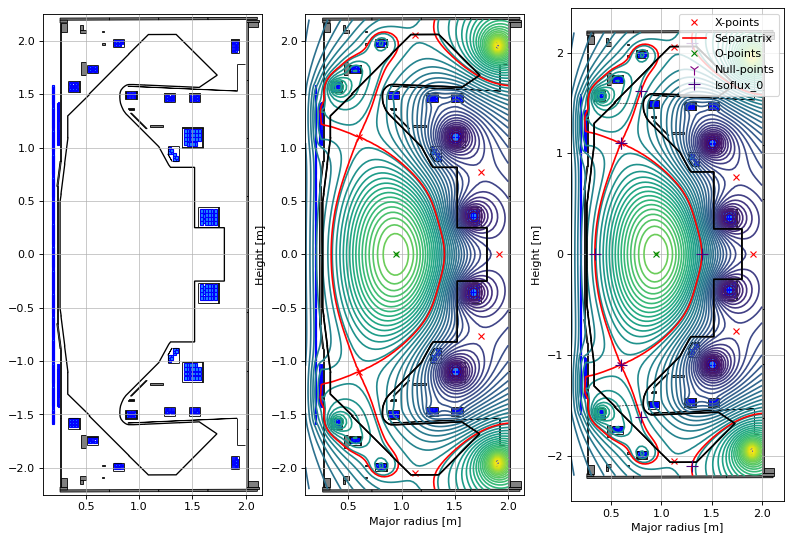

<Figure size 640x480 with 0 Axes>

In [9]:
fig1, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 8), dpi=80)

ax1.grid(zorder=0, alpha=0.75)
ax1.set_aspect('equal')
eq.tokamak.plot(axis=ax1,show=False)                                                          # plots the active coils and passive structures
ax1.fill(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, facecolor='w', zorder=0)   # plots the limiter
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)

ax2.grid(zorder=0, alpha=0.75)
ax2.set_aspect('equal')
eq.tokamak.plot(axis=ax2,show=False)                                                          # plots the active coils and passive structures
ax2.fill(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, facecolor='w', zorder=0)   # plots the limiter
eq.plot(axis=ax2,show=False)                                                                  # plots the equilibrium
ax2.set_xlim(0.1, 2.15)
ax2.set_ylim(-2.25, 2.25)


ax3.grid(zorder=0, alpha=0.75)
ax3.set_aspect('equal')
eq.tokamak.plot(axis=ax3,show=False)                                                          # plots the active coils and passive structures
ax3.fill(tokamak.wall.R, tokamak.wall.Z, color='k', linewidth=1.2, facecolor='w', zorder=0)   # plots the limiter
eq.plot(axis=ax3,show=False)                                                                  # plots the equilibrium
constrain.plot(axis=ax3, show=True)                                                          # plots the contraints
ax3.set_xlim(0.1, 2.15)
ax3.set_ylim(-2.25, 2.25)

plt.tight_layout()

A solve call will modify the equilibrium object in place. That means that certain quantities within the object will be updated as a result of the solve. 

Various different quantities and functions can be accessed via the 'eq' and 'profile' objects. For example:
- the total flux can be accessed with `eq.psi()`.
- the plasma flux with `eq.plasma_psi`.
- the active coil + passive structure flux with `eq.tokamak.psi(eq.R, eq.Z)`.
- (Total flux = plasma flux + coil flux)

Explore `eq.` to see more (also `profiles.`, e.g. the plasma current distribution over the domain can be found with `profiles.jtor`). Also see the `example3` notebook for how to access many different equilibrium-derived quantities of interest. 

The set of optimised coil currents can be retrieved using `eq.tokamak.getCurrents()` having been assigned to the equilibrium object during the inverse solve.

The following lines will save the calculated currents to a pickle file (we will use these in future notebooks). 

In [10]:
inverse_current_values = eq.tokamak.getCurrents()

# save coil currents to file
import pickle
with open('data/simple_diverted_currents_PaxisIp.pk', 'wb') as f:
    pickle.dump(obj=inverse_current_values, file=f)

### Second inverse solve: limited plasma example

Below we carry out an inverse solve seeking coil current values for a limited plasma configuration (rather than a diverted one). 

In a limiter configuration the plasma "touches" the limiter of the tokamak and is confined by the solid structures of the vessel. The last closed flux surface (LCFS) is the closed contour that is furthest from the magnetic axis that just barely touches (and is tangent to) the limiter.

We instantiate a new equilibrium but use the same profile (illustrating how to vary the total plasma current and pressure on axis within it) and solver objects.

In [11]:

# a new eq object resets the coil currents and equilibrium
eq = equilibrium_update.Equilibrium(
    tokamak=tokamak,      # provide tokamak object
    Rmin=0.1, Rmax=2.0,   # radial range
    Zmin=-2.2, Zmax=2.2,  # vertical range
    nx=65,                # number of grid points in the radial direction (needs to be of the form (2**n + 1) with n being an integer)
    ny=129,               # number of grid points in the vertical direction (needs to be of the form (2**n + 1) with n being an integer)
    # psi=plasma_psi
)

# modify the total plasma current
profiles.Ip = 4e5

# modify the pressure on the magnetic axis
profiles.paxis = 6e3

# first we specify some alternative constraints
Rout = 1.4   # outboard midplane radius
Rin = 0.24   # inboard midplane radius

# locations of X-points
Rx = 0.45
Zx = 1.18
null_points = [[Rx, Rx], [Zx, -Zx]]

# isoflux constraints
isoflux_set = [[Rx, Rx, Rout, Rin, Rin, Rin, Rin, Rin, .75, .75, .85, .85, 1.3, 1.3],
           [Zx, -Zx,  0,  0,  .1, -.1, .2, -.2, 1.6, -1.6, 1.7, -1.7, 2.1, -2.1]]

# let's assume we're also seeking an equilibrium with no solenoid current
eq.tokamak.set_coil_current('Solenoid', 0)
eq.tokamak['Solenoid'].control = False # fixes the current

# pass the magnetic constraints to a new constrain object
constrain = Inverse_optimizer(null_points=null_points,
                              isoflux_set=isoflux_set)

# carry out the solve
GSStaticSolver.solve(eq=eq, 
                     profiles=profiles, 
                     constrain=constrain, 
                     target_relative_tolerance=1e-6,
                     target_relative_psit_update=1e-3,
                     verbose=True, # print output
                     l2_reg=np.array([1e-9]*10+[1e-5]), 
                     )

-----
Inverse static solve starting...
Initial guess for plasma_psi successful, residual found.
Initial relative error = 9.72e-01
-----
Iteration: 0
Using simplified Green's Jacobian (of constraints wrt coil currents) to optimise the currents.
Change in coil currents (being controlled): ['7.00e+03', '8.05e+02', '2.84e+04', '3.23e+04', '-1.77e+04', '2.89e+04', '-2.57e+04', '-1.29e+04', '-4.43e+04', '1.54e+04', '-1.64e-05']
Constraint losses = 8.85e-01
Relative update of tokamak psi (in plasma core): 1.58e+00
Handing off to forward solve (with updated currents).
Relative error =  9.53e-01
-----
Iteration: 1
Using simplified Green's Jacobian (of constraints wrt coil currents) to optimise the currents.
Change in coil currents (being controlled): ['-2.89e+03', '-1.94e+03', '-8.93e+03', '-1.01e+04', '5.62e+03', '-9.48e+03', '7.97e+03', '3.99e+03', '1.42e+04', '-3.89e+03', '-1.50e-05']
Constraint losses = 3.03e-01
Relative update of tokamak psi (in plasma core): 2.14e-02
Handing off to forwar

In [12]:
# save the currents for later use
inverse_current_values = eq.tokamak.getCurrents()

# save coil currents to file
with open('data/simple_limited_currents_PaxisIp.pk', 'wb') as f:
    pickle.dump(obj=inverse_current_values, file=f)

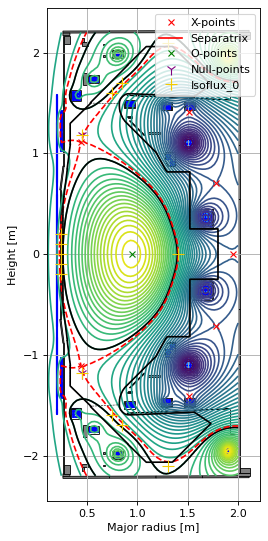

<Figure size 640x480 with 0 Axes>

In [13]:
# plot the resulting equilbria 
fig1, ax1 = plt.subplots(1, 1, figsize=(4, 8), dpi=80)
ax1.grid(True, which='both')
eq.plot(axis=ax1, show=False)
eq.tokamak.plot(axis=ax1, show=False)
constrain.plot(axis=ax1,show=True)
ax1.set_xlim(0.1, 2.15)
ax1.set_ylim(-2.25, 2.25)
plt.tight_layout()